# Introduction

This repo contains code for implementing a 1D stochastic molecule simulation with discretized time in the gymnasium environment, allowing one to use reinforcement learning to investigate the properties of near-optimal controllers. It also contains several example programs used to investigate the utility of reinforcement learning in understanding control of stochastic molecular dynamics.

It is known in the literature for stochastic molecular dynamics that [control schemes based on the entire history of molecular levels offer superior performance to controllers that only act based on instantaneous values](https://www.nature.com/articles/nature09333), but such control mechanisms are difficult to derive analytically. Here, we show the improvements available from sampling molecular histories instead of instantaneous values by using reinforcement learning on the problem of delayed molecular controllers, where we find that the variance compared to a lagg-free controller can be reduced by up to 14% by predicting based off the past 3 observations instead of only the most recent value.

This is pictured in the following graph, showing that a control mechanism (learned via machine learning) with delays can more effectively approach the performance of the optimal no-delay controller by using histories of molecular trajectories.

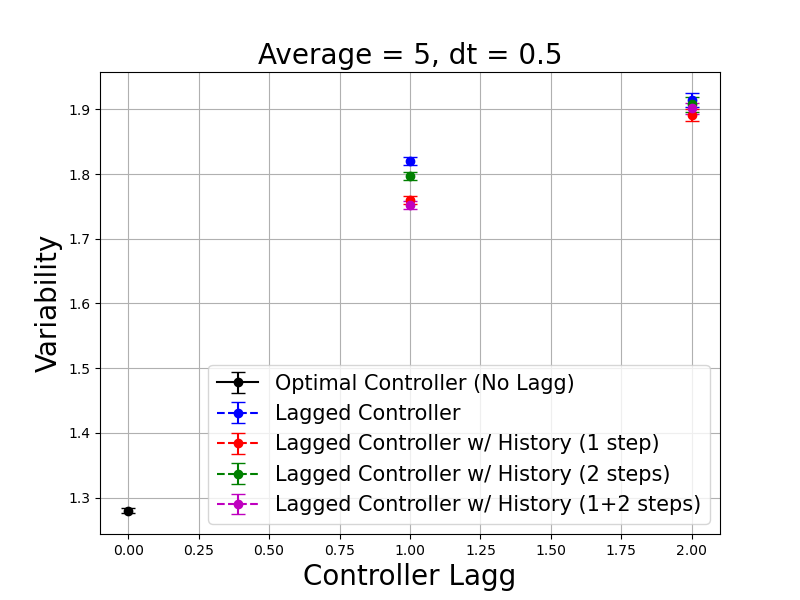

In [9]:
from IPython.display import Image, display

# Specify the filename of the image
image_filename = "Comparison_Of_Avg5_dt05.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

# Purpose

Reducing variability is a common goal in many control applications. In this program, we analyze the properties of near-optimal controllers for a discrete time process where a finite number of molecules randomly decay between timesteps with probability $p$. The controller only sees the number of molecules at the current timestep $N_k$ (or potentially a number of pevious timesteps $N_{k -1}, N_{k - 2}...$) and must decide upon the optimal amount of number of molecules to be produced in the next step to ensure that the observed number of molecules at the next timestep is as close to a target $B$ as possible, with the goal being the minimize the error, given by the squared differenece between the number of molecules and the target.

This problem can be analytically solved in the case where the controller observes exactly the current number of molecules before making it's decision for the next timestep, where the optimal number of molecules to send in at timestep k, $A_k$ is given by the closest integer to

\begin{equation}
A_{k, cont.} = B - N_{k}(1 - p)
\end{equation}

obtained by minimizing expected value of the squared difference. This result implies the number of molecules made should compensate for the average number of molecules lost. Unfortunately, analytically solving for the average error is difficult, and one must use numerical simulations. For the details of this solution, see the folder "Theoretical Results".

Because this system is a markov chain, there is no increase in predicting future values of molecules given we know the current number of molecules. However, if our controller does not observe the most recent value of the abundance, but instead a lagged history of molecular abundances (while simultaneously receiving error estimates based on the current but invisible value), this markov property does not hold, and observing large histories of the current molecule may result in increased performance. 

Such controllers are difficult to analytically solve for. Instead, we implement a reinforcement learning algorithm to learn a near-optimal controller for us.

## Near Optimal Controllers with Reinforcement Learning

Reinforcement learning is a branch of machine learning concerned with teaching agents to solve problems by providing them with rewards and punishments based off performance. We will use it here to create a controller that will take in as input a history of the past molecular observations, and output the number of molecules it believes should be added into the system at this timestep. 

### Environment

Reinforcement learning requires an environment - in this case, a simulation of the system to learn from. We implemented this system in pythons gymnasium library, a standard library for reinforcement learning algorithms. Our environment takes in 

- Initial number of molecules
- Average molecule lifetime $t_{mol}$
- dt, the time between observations
- The maximum number of steps to run the simulation for
- The length of history of the molecule's abundances
- the target value
- the maximum number of molecules allowed in the system

which is used to compute the probability a molecule does not decay $p = exp(-dt/t_{mol})$. At every step, it takes in an action by the controller, and computes the number of molecules that have decayed since the last observation (drawn from a binomial with probability $p$ before adding in the action, and returning the history of the molecules abundances, the reward (negative squared difference between the current value and the target), and the actual optimal number of molecules to send in, along with some generic flags for gymnasium libraries.

### Neural Networks

At first, I tried a neural network approach. The network learns using the loss, given by the squared difference between the network's taken action and the optimal action. This network is capable of learning, but comparing it to the analytic optimal controller for this problem reveals that it consistently does worse than the optimal solution, and furthermore it's performance does not improve with more training. This is a common problem in the field of deep reinforcement learning, where increased amounts of training do not result in greater performance, as shown here by the departure of the neural net predictions from the optimal controller.

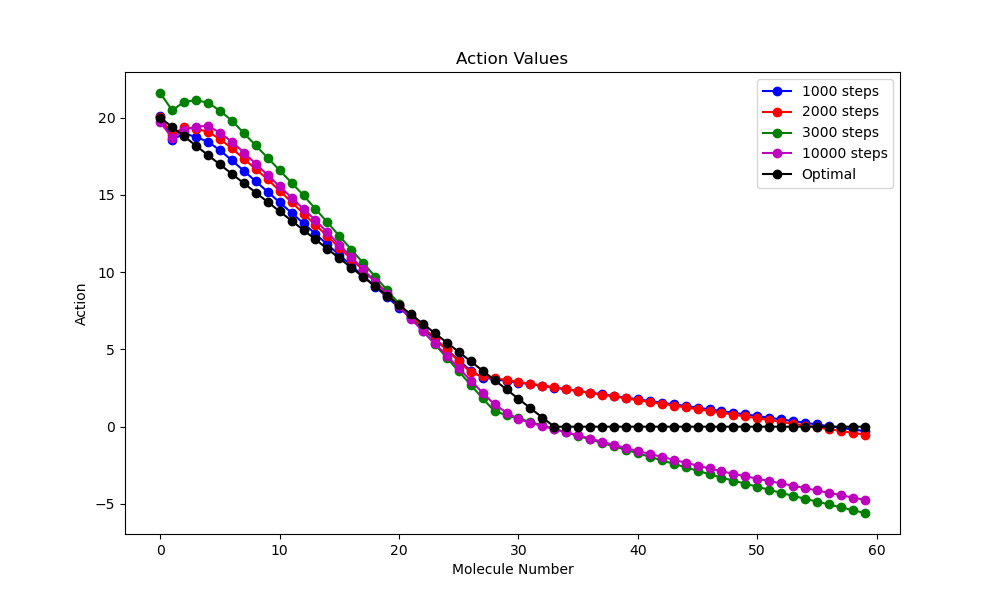

In [2]:
# Specify the filename of the image
image_filename = "Neural_Nets_Get_Worse.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

For details, see "Neural Nets.ipynb"

### Tabular Methods

An alternative to using neural networks is lookup tables. Unlike networks, they cannot infer general principles and solve problems that they have never observed and are only suitable for small action spaces due to memory constraints, but in exchange they never undergo common issues with deep learning RL approaches such as catastrophic forgetting. Since the state space of our problem is relatively small and our interest is in producing near-optimal controllers, they work well for this problem.

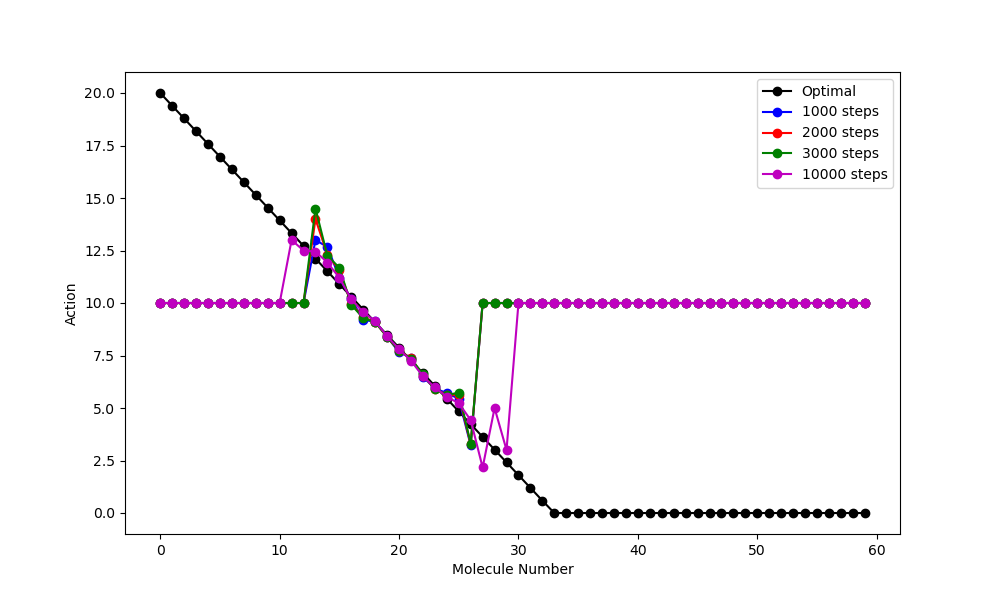

In [3]:
# Specify the filename of the image
image_filename = "Lookup_Tables_get_better.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

For details, see "Lookup Tables.ipynb".

### Analyzing The Performance Of Our Machine Learning Model

Learning curves are not effective measures of performance in this problem, because the systems learn the solution very quickly but are still subject to significant intrinsic noise. The significant intrinsic noise is much more notable than any increase from further training. Instead, to demonstrate our solutions performance, we run it for 100000 steps, and take the average of the last 50000 steps as the average error, and sample across multiple seeds to compare it's performance against the known optimal solution. We do this across a variety of averages and temporal resolutions. For the code, see the folder "Analytic Model".

#### Averages

The machine learning solution and the analytic optimal solution match closely. The variability rises linearly as a function of the average. The results are run for 10 different seeds to produce points with error bars.

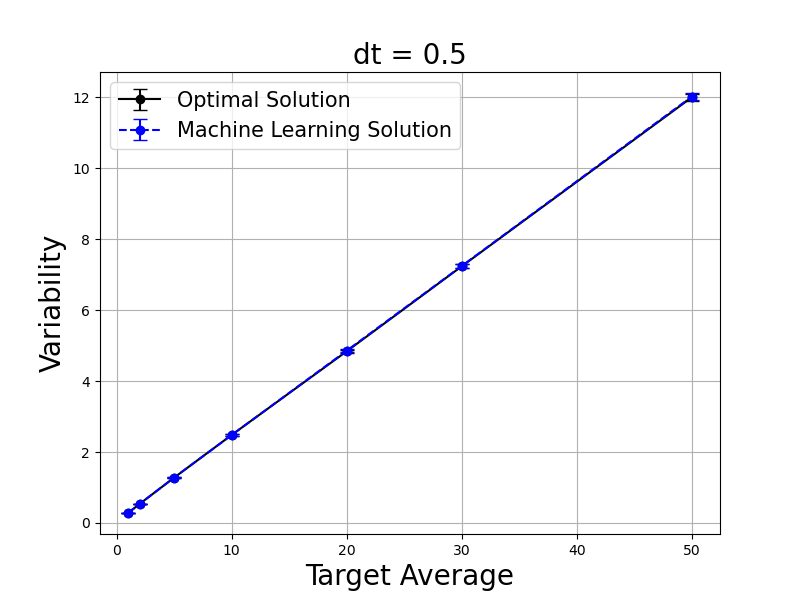

In [4]:
# Specify the filename of the image
image_filename = "d05_comparison_analytic_model.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

### Temporal Resolution

Instead of comparing our analytic solution with our machine learning solution across a variety of averages, we can instead vary the time between timesteps (dt). We find again there is fairly good agreement between the two methods, except for an issue at $dt = 0.01$.

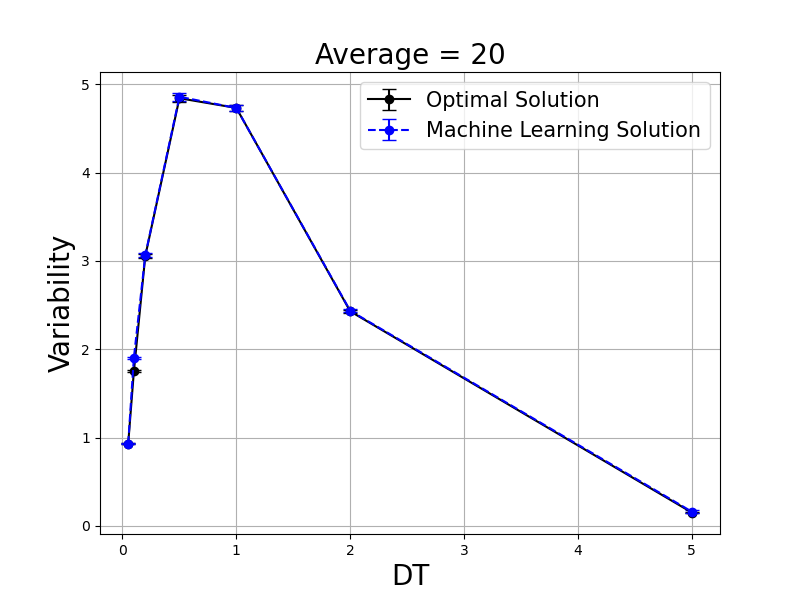

In [6]:
# Specify the filename of the image
image_filename = "avg20_comparison_analytic_model.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

Note that variability is a nonlinear function of the temporal resolution. This is because very small and very small timesteps are easy to control: in the former, only one molecule decays at most, while in the latter, almost all molecules are guaranteed to have decayed. Ensuring that the target value is met is simple because the source of the randomness (decays) is very small.

However, this large timestep limit is not very useful - it is an artifact of how we've chosen to implement our simulation, and the low variability in this case is not useful for actual control problems. Thus for further analysis, we stick to analyzing across a variety of averages with a modest timestep ($dt = 0.5$)

### Testing Markovianity

The system being controlled is markovian (the history of molecule numbers offers no predictive advantage if the most recent molecule count is known). We can test to see if our controller can learn this, modifying our algorithm to keep track of and use a larger history of molecular values. This should produce the same performance as before (matching the optimal solution which only uses the latest value), which is what we observe. However, there is a slight performance loss at higher averages, which makes sense since our system will now learn much slower since it is tracking non-useful variables and higher averages take longer to learn.

For the code, see folder "Extra Histories".

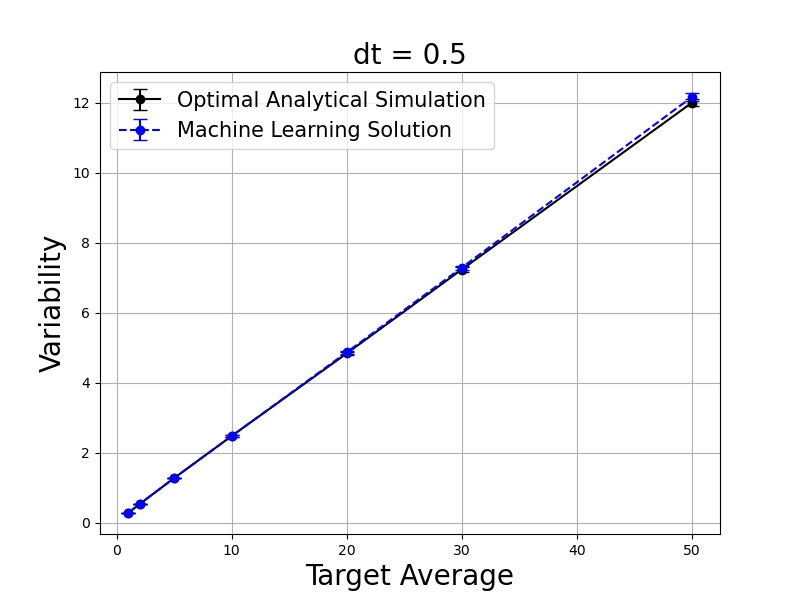

In [7]:
# Specify the filename of the image
image_filename = "d05_comparison_extra_history.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

We can also plot our controller's actions in 2D plot, which shows the machine learning controller only cares about the most recent molecular value when making predictions to minimize future variability. This is show by the constant values along the lagged axis.

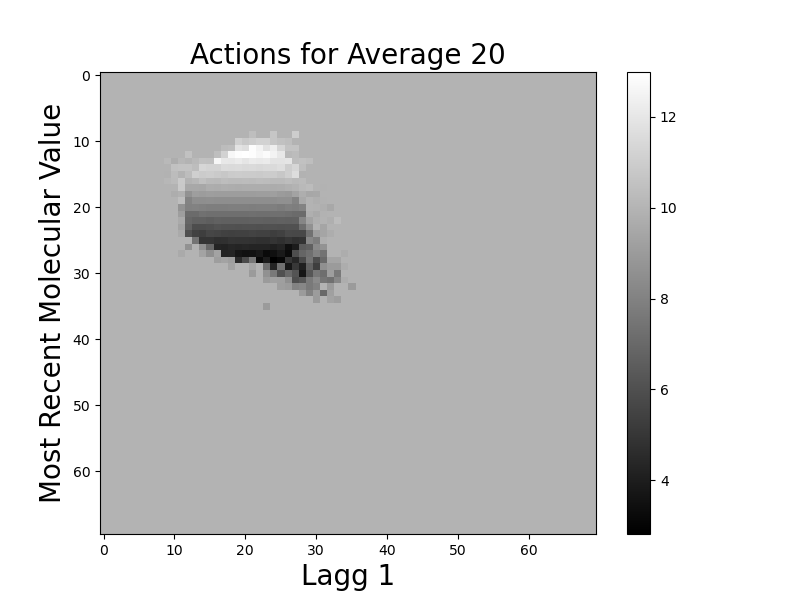

In [8]:
# Specify the filename of the image
image_filename = "action_values_extra_history.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

Note that if the value of the molecule 1 timestep ago was very large, then theres a large chance the current value is large (reflected by the large bottom left corner of learned values).

## Non-Analytic Control Problems

Having shown our machine learning algorithm can match our optimal analytic controller for simple problems, we apply it to a complex case where analytic controllers are difficult to solve for. For the code, see folder "Non-Markovian Models".

### Lagged Controllers

The case studied here is a delayed controller: it's actions will not be enacted at the next timestep (as was done previously) but instead is performed several timesteps later. This case is studied in the folder "Non-Markovian Models" because the system is no longer Markovian in the variables seen by the controller, and the controller does notably worse compared to the instantaneous controller.

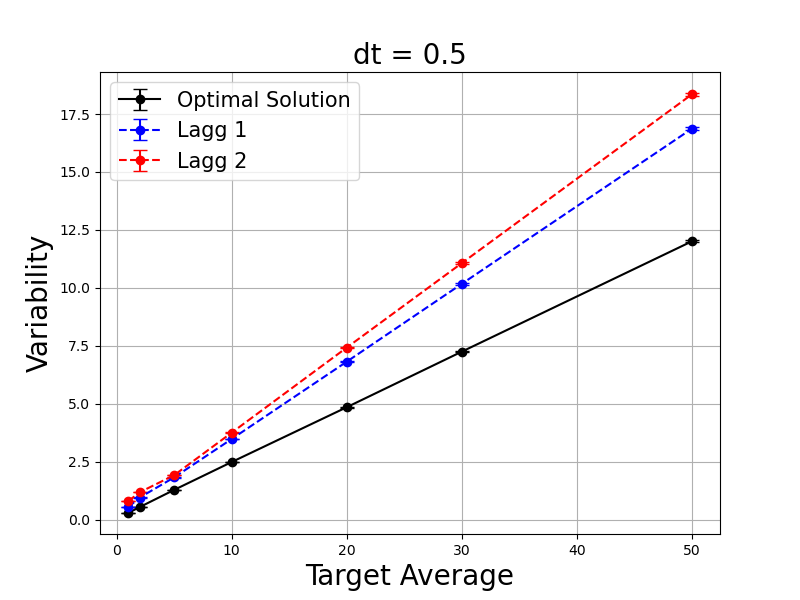

In [3]:
# Specify the filename of the image
image_filename = "Lagg_Makes_Worse_Controllers_dt05.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

Note that more delay (lagg) results in worse performance in controlling the variability. The blue and red curves are obtained by running our machine learning algorithm using most recent observation available to the controller.

### History Dependent Machine Learning Controllers Can Improve Performance

By running our machine learning algorithm on this model and allowing it to use information from older observations (not just the most recent observation) we can improve the performance of our algorithm. Intuitively, this is because by knowing the history of values observed by the controller, it can estimate to some degree the inputs the molecule will see in the future (beyond the current value observed by the controller) and the variability lies only in the number of deaths and not in the number of molecular production events.

This is most apparent if we plot the optimal actions of our controller in the case where it observes the two most recent values, which now show a clear dependence on older observations compared to the simple markovian model.

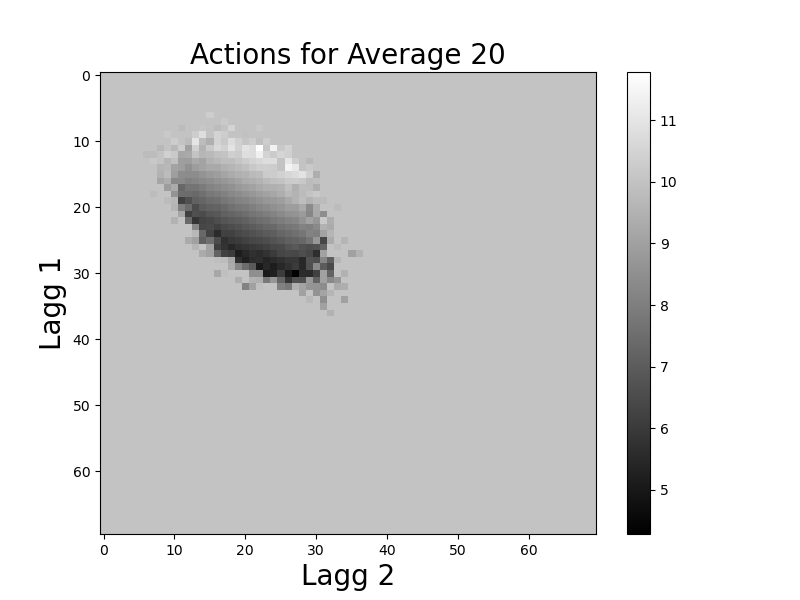

In [4]:
# Specify the filename of the image
image_filename = "action_values_lagg1_history1.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

Although the change in controller behaviour is striking, the performance gain is less obvious.

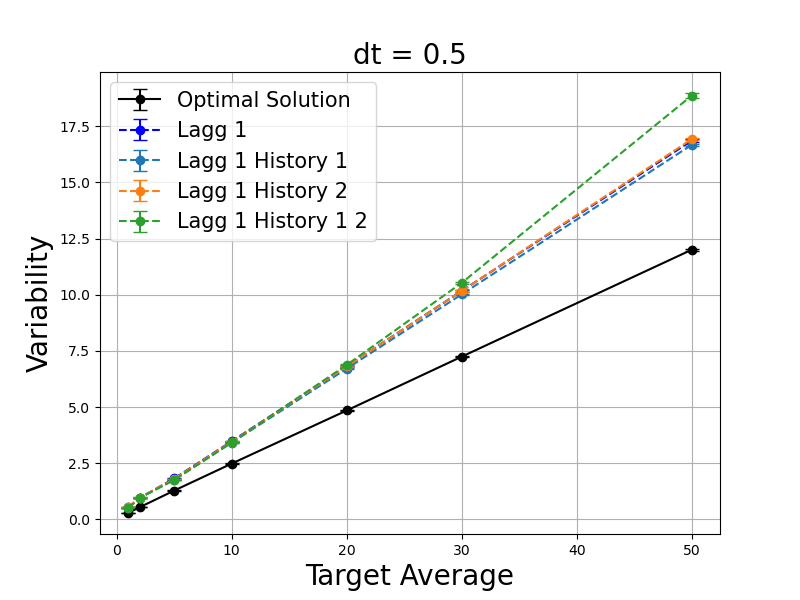

In [6]:
# Specify the filename of the image
image_filename = "Lagg1_With_History_dt05.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

The controllers using additional observations (History 1, 2, and 1 2) perform somewhat better than the controller trained on only the latest observation, but the more complex controllers do worse at larger averages, suggesting that they require more training time (because of the larger state space for larger averages and complex controllers). We can more accurately evaluate the performance of the controllers by comparing the results at a small average, such as an average of 5:

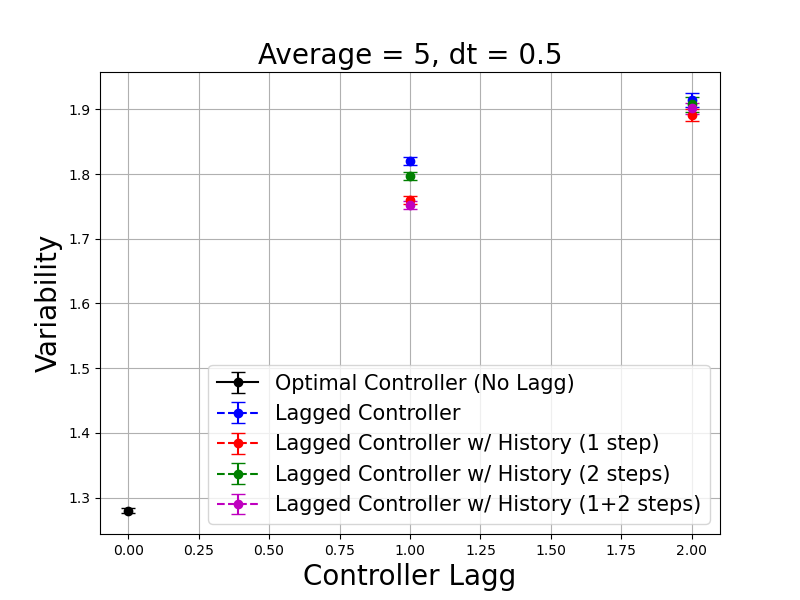

In [8]:
# Specify the filename of the image
image_filename = "Comparison_Of_Avg5_dt05.png"  # Replace with your image file name

# Display the image
display(Image(filename=image_filename))

### Numerical Results

The effect of a history dependent controller reduced the variability from  1.82  to  1.752. The minimal variability for this average and temporal resolution with a controller without any delay is 1.28. The effect of using histories in our machine learning algorithm has reduced the error from this optimal performance from 0.42 to 0.37, resulting in a 14 percent improvement from using histories.

In general, investigating other average lengths results in a performance of slightly less, around 5% (which can be attributed to the longer training times needed for our controller to learn more complex control schemes).

# Future Steps

Future directions to take this repo are:

- Running simulations with larger training times, to see if the increase in performance is consistent across all averages
- Comparing lookup tables with deep learning approaches which can generalize and may learn more complex controllers faster
- Implementing more baseline controllers to compare the machine learning approach against (eg, what if we run the optimal control algorithm but using the lagged inputs, vs our machine learning controller?)
- More complicated gym environments to investigate more interesting questions (eg, given that we control a molecule using only the abundance of a downstream molecule, what is the optimal lifetime ratio of the downstream molecule relative to the fluctuations of the controlled molecule to make the best controllers? This may have biological implications for the optimal lifetime of reporter molecules.)